#  Provenance integration in netcdf/xarray Data-Intensive workflows.


#### Authors: Alessandro Spinuso and Andrej Mihajlovski, 

####  Royal Netherlands Meteorological Institure (KNMI)


The following "Live" notebook demonstrates a simple workflow implemented with a data-intensive processing library (dispel4py), that has been extended with a configurable and programmable provenance tracking framework.

## Management Highligts, S-PROV Towards reproduciblity as a service
<ul>
<li>
The provenance information produced can be tuned and adapted to computational, precision and contextualisation requirements</li>
<li>
The freamework allows for the traceability of data-reuse across different executions, methods and users</li>
<li>The provenance can be stored as files or sent at run-time to a custom external repository</li>
<li>The repository can be searched and explored via interactive tools</li> 
<li>The provenance model is designed around an hybrid data-flow model, which takes into account data-streams and concrente data resourcese. eg. file location, webservices etc.</li>
<li>The lineage can be exported from the repository in W3C PROV format. This facilitates the production of interoperabile reports and data-curation tasks. For instance, The provenance related to specific data can be stored in W3C-PROV XML format into strucutred file formats (NetCDF) as well as istitutional and general-purpose citable data-repositories.</li>
</ul>

## Demonstration outline

### 1 - Workflow specification and execution

<ol>
  <li>Define the <i><b>Classes</b></i> of the <i><b>Workflow Components</b></i></li>
  <li>Construct the <i><b>Workflow</b></i> application</li>
  <li>Prepare the Input</li>
  <li>Visualise and run the workflow without provenance</li>
</ol>

### 2 - Provenance Types, Profiling and contextualisation

<ol>
  <li>Define the <i><b>Provenance Type</b></i> to be used within the workflow</li>
  <li><i><b>Profile</b></i> the workfow for provenance tracking</li>
  <li>Visualise and run workfow with provenance activatied</li>
  <li>Export and embed provenance within NetCDF results</li>
  <li>Explore the resulting provenance with interactive and static visualsations</li>
</ol>

### 3 - Data-reuse traceability. 
<ol>
  <li>Change the input and demostrate consistency of provenance for data-ruse across multiple workflow executions</li>
  <li>Discuss more complex use cases and configuration options</li>
</ol>

### 4 - Informal Evaluation

SWOT form:

https://docs.google.com/presentation/d/10xlRYytR7NB9iC19T29BD-rW77ZAtnjtlukMJDP_MIs/edit?usp=sharing


## 1 - Workflow specification and execution


<ul>
<li>The dispel4py framework is utilised for the workflows</li>
<li>Xarray for inmemory management of netcdf/opendap data.</li>
<li>Matplotlib for visualisation.</li>
<li>W3C for provenance representation.</li>
</ul>

In [1]:
import xarray
#import netCDF4
import json

from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *

from collections import OrderedDict
import time
import random

from dispel4py.base import create_iterative_chain, ConsumerPE, IterativePE, SimpleFunctionPE

import matplotlib.pyplot as plt
import traceback

from pprint import pprint

Simple Workflow, xarray in xarray out. 
The generic processing elements are defined below. the <i>GenericPE</i> bellongs to the dispel4py framework. It allows data-objects to be passed as inputs and outputs. The <i>Components</i> are linked and visualised via the workflow_graph module.

### 1.1 The three Workflow Components:

<ol>
<li>- Read, xarray is read into memory.</li>
<li>- ANALYSIS, xarray is processed/passed to output (dummy, no real changes in the example)</li>
<li>- Write, xarray is visualised.</li>
</ol>

In [2]:
class Read(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('xarray')

    def _process(self,inputs):
        self.log('Read_Process')
     
        self.log(inputs)
        
        inputLocation = inputs['input'][0]

        ds = xarray.open_dataset( inputLocation )
    
        self.write( 'xarray' , (ds , inputs['input'][1]) , location=inputLocation )

            
class Write(IterativePE):
    
    def __init__(self):
        IterativePE.__init__(self)
        #self._add_input('input')
        #self._add_output('location')
        
    def _process(self,inputs):
        self.log('Write_Function')
        self.log(len(inputs))
        
        outputLocation = inputs[1]
        
        inputs[0].to_netcdf( outputLocation )
                
        self.write('location', outputLocation,location=outputLocation )
        
        
class Analysis(GenericPE):
        
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output')
        
    def _process(self,inputs):
        self.log('Workflow_process')
        
        self.log(inputs.keys())
        
        #nc = inputs['input'][0]
        nc = inputs['input'][0]
        #self.log(nc)
        #
        self.write('output', (nc , inputs['input'][1] ))


class CombineWorkflow(GenericPE):
     
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('combine1')
        self._add_input('combine2')
        self._add_output('combo')
        
        self.nc1 = None
        self.nc2 = None
        self.out = None
        
    def _process(self,inputs):
        self.log('Combine_process')
        self.log(inputs.keys())
        
        if 'combine1' in inputs.keys():
            self.nc1 = inputs['combine1'][0]
            self.out = inputs['combine1'][1]
        
        if 'combine2' in inputs.keys():
            self.nc2 = inputs['combine2'][0]
            self.out = inputs['combine2'][1]
        
        if (self.nc1 is not None) and (self.nc2 is not None):
            nc = self.nc1
             
            self.log(len(self.nc2.attrs.items()))
            for k,v in self.nc2.attrs.items():
                if k in nc.attrs.keys():
                    nc.attrs[k] = v
                else:
                    nc.attrs[k] = v
            
            #self.log( type(nc))
        
            self.write('combo', (nc , self.out ))




### 1.2 Construct the Workflow application

Instantiates the Components and combines them in a workflow graph which gets eventually visualised

SETTING NAME: Read
SETTING NAME: Read
SETTING NAME: Analysis
SETTING NAME: Analysis
SETTING NAME: CombineWorkflow
SETTING NAME: Write


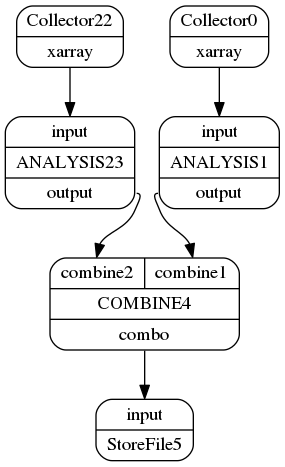

In [3]:

#Initialise the graph
def createWorkflowGraph():
    readX  = Read()
    readX.name = 'Collector'
    readY  = Read()
    readY.name = 'Collector2'
    
    analyse   = Analysis()
    analyse.name    = 'ANALYSIS'
    analyse.parameters = { 'filter': 10 }

    analyse2   = Analysis()
    analyse2.name    = 'ANALYSIS2'
    analyse2.parameters = { 'filter': 13 }
    
    wf3     = CombineWorkflow()
    wf3.name    = 'COMBINE'
    wf3.parameters = { 'wf':'paramC' }
    
    writeX = Write()
    writeX.name = 'StoreFile'
    
    
    graph = WorkflowGraph()    
    
    graph.connect(readX ,'xarray'   , analyse      ,'input')
    graph.connect(readY ,'xarray'   , analyse2     ,'input')
    
    graph.connect( analyse  ,'output'   , wf3     ,'combine1')
    graph.connect( analyse2 ,'output'   , wf3     ,'combine2')
    
    graph.connect(wf3    ,'combo'   , writeX , 'input')

    return graph



graph = createWorkflowGraph()


from dispel4py.visualisation import display
display(graph)




### 1.3 Specify the Input

A simple json representation is used to define initial input data for each named Component of the workflow.
Every component can recieve a list of inputs. These will be streamed serially or in parallel, depending from the execution mode

In [4]:
input_data = { 
                #'Collector': [ { 'input': [ 'data/new0.nc', 'data/newA.nc']} ]
                
                #'Collector': [ { 'input' : [ 'http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc',
                #                'data/newA.nc']}]
    
                #'Collector': [ { 'input': [ 'data/newA.nc', 'data/newB.nc']} ]     
                #'Collector': [ { 'input': [ 'data/newA.nc', 'data/newB.nc']} ,  { 'input': [ 'data/newA.nc', 'data/newC.nc']} ] 
                'Collector' : [ { 'input': [ 'data/new0.nc', 'data/newY.nc']}],
                'Collector2': [ { 'input': [ 'data/new0.nc', 'data/newY.nc']}]
            }



### 1.3 Run the Workflow



In [5]:
global result

def runExampleWorkflow():
                                                     
    print input_data                   

    #Launch in simple process
    result = simple_process.process_and_return(graph, input_data)
    print "\n RESULT: "+str(result)

runExampleWorkflow()

{'Collector': [{'input': ['data/new0.nc', 'data/newY.nc']}], 'Collector2': [{'input': ['data/new0.nc', 'data/newY.nc']}]}
SETTING NAME: SimpleProcessingPE
Collector0: Read_Process
Collector0: {'input': ['data/new0.nc', 'data/newY.nc']}
ANALYSIS1: Workflow_process
ANALYSIS1: ['input']
Collector22: Read_Process
Collector22: {'input': ['data/new0.nc', 'data/newY.nc']}
ANALYSIS23: Workflow_process
ANALYSIS23: ['input']
COMBINE4: Combine_process
COMBINE4: ['combine1']
COMBINE4: Combine_process
COMBINE4: ['combine2']
COMBINE4: 22
StoreFile5: Write_Function
StoreFile5: 2
SimplePE: Processed 1 iteration.

 RESULT: {'StoreFile5': {'location': ['data/newY.nc']}}


## 2 - Provenance Types, Profiling and contextualisation

### 2.1 Define a Provenance Type

The <i>Provenance Type</i> defined below will be used to extend specific workflow components, enabling special provenance tracking properties for <i>NetCDF/xarray</i> formats.


<ul>
<li>
<i>makeUniqueId</i>: Generates and returns a \emph{uuid}. This can be implemented to adhere to the hosting infrastructure best-practices.</li>
<li>
<i>extractExternalInputDataId</i>
This method is used by the provenance type to extract the id of the incoming data. Its use is handy especially when a workflow component ingests files that have been produced by other workflows and that are represented by self-contained and structured data formats.  For instance, in NetCDF where data and metadata can be packaged together according to community standards, this method extracts and returns the id of the external resource, allowing the framework to use it in the current run to represent new dependencies. A customised implementation of this method for a provenance type that deals with domain-specific data formats, ensures the linkage and therefore the consistent continuation of provenance traces across workflow executions. </li>
<li><i>extractItemMetadata</i>
This methods enables the configuration of the provenance for a particular domain, user or infrastructure requirement. It extracts metadata from the data written on a output channel and includes it as a detailed description of the <i>Data</i> entity within the provenance model.</li>
</ul>


In [6]:
class netcdfProvType(ProvenancePE):
    def __init__(self):
        ProvenancePE.__init__(self)
    
    def extractExternalInputDataId(self,data, input_port):
        #Extract here the id from the data (type specific):

        self.log('ANDREJ.extractExternalInputDataId')
        #self.log(data)
        
        try:
            #ds = xarray.open_dataset(data['input'][0])
            ds = xarray.open_dataset(data[0])
            id = ds.attrs['id']
            
        except Exception, err:
            id = str(uuid.uuid1())
            self.log(str(err))
        #Return
        return id
    
    
    def makeUniqueId(self, data, output_port):      
        
        self.log('ANDREJ.makeUniqueId')
        #self.log(kwargs)
        
        #produce the id
        id=str(uuid.uuid1())
            
        ''' nc data '''
        xa = data[0]
        
        ''' unique as defined by the community standard '''
        xa.attrs['id'] = id
        
        #Return
        return id 
    

    
    ''' extracts xarray metadata '''
    def extractItemMetadata(self, data, output_port):
        
        self.log('ANDREJ.extractItemMetadata')
        #self.log(data)
        
        try:            
            nc_meta = OrderedDict()
            
            ''' cycle throug all attributes, dimensions and variables '''
            xa = data[0]
                        
            # dataset meta
            nc_meta['Dimensions'] = str( dict(xa.dims)) 
            nc_meta['Type'] = str(type(xa))
            
            # global attr
            for k , v in xa.attrs.items():
                nc_meta[str(k).replace(".","_")] = str(v)
            # vars attr   
            for n , i in xa.data_vars.items():
                for k , v in i.attrs.items():
                    nc_meta[n+"_"+str(k).replace(".","_")] = str(v)
            
            #pprint(nc_meta)
        
            metadata = [nc_meta]
            
            return metadata
                             
        except Exception, err:
            self.log("Applying default metadata extraction:"+str(traceback.format_exc()))
            self.error=self.error+"Extract Metadata error: "+str(traceback.format_exc())
            return super(netcdfProvType, self).extractItemMetadata(data);
        
        
        
        
class StatefulProvType(ProvenancePE):
    def __init__(self):
        ProvenancePE.__init__(self)
        
    def apply_state_reset_policy(self, event,value):
        #self.log('ALE.apply_state_reset_policy '+str(event)+'_'+str(value))
        
        if( event == 'void_iteration' and value == True ):
            self.log('ALE.apply_state_reset_policy '+str(event)+' '+str(value))
            self.resetflow = False
        else:
            self.resetflow = True
        

### 2.2 Profile the workfow for provenance tracking

Once the Provenance types have been defined, these are used to configure, or profile, a workflow execution to comply with the desired provenance collection requirements.  Below we illustrate the framework method and the details of this approach.

<ul>

<li><i>profile_prov_run<\i> With this method, the users of the workflow can profile their run for provenance by indicating which types to apply to each component. These will be assigned following the approach illustrated in Figure \ref{dytyp}.  Users can also chose where to store the metadata, locally to the file system or to a remote service. These operations can be performed in bulks, with different impacts on the overall overhead and on the experienced rapidity of the access of the lineage information. Additional details on the proposed remote provenance storage and access service will be provided in Chapter V. Finally, also general information about the attribution of the run, such as \emph{username, run\_id, description, workflow\_name, workflow\_id} are captured and included within the provenance traces.
<\li>

<li><i>Skip-Rules (Advanced)<\i>
Users can tune the scale of the records produced by indicating in the above method a set of \emph{skip-rules} for every component.This functionality allows users to specify rules to control the data-driven production of the provenance declaratively. The approach takes advantage of the contextualisation applied by the provenance types, which extract domain and experimental metadata, and evaluates their value against simple <i>skip-rule<\i> of this kind:
<\li>
<\ul>




In [7]:
skip_rules={"ANALYSIS":{"term":{"$gt":0,"$lt":100}}}

A high level 'template/profile' describing the provenance process.

In [8]:
prov_profile =  {
                    'username': "andrej", 
                    'w3c_prov': False   ,
                    'description' : "provdemo combo",
                    'workflowName': "demo_ecmwf"      ,
                    'workflowId'  : "workflow process",
                    'save_mode'   : 'service'         ,
    
                 # defines the use of the ProvenancePE with the Workflow element
                    #'componentsType' : {'Workflow':(netcdfProvType,) , 'Collector':(netcdfProvType,),'Write':(netcdfProvType,)}
                    'componentsType' : {'ANALYSIS':(netcdfProvType,) ,'ANALYSIS2':(netcdfProvType,) ,'COMBINE':(netcdfProvType, StatefulProvType) , 'Collector':(netcdfProvType,), 'Collector2':(netcdfProvType,)},
                    'skip_rules': skip_rules
                } 


The REPOS_URL is the target provenence depo. Used as a production tool for VERCE (Seismo), CLIPC (C3S) and Climate4Impact (Climate IS-ENES)

In [9]:
#Store via service
#ProvenancePE.REPOS_URL='http://127.0.0.1:8082/workflow/insert'
ProvenancePE.REPOS_URL='http://climate4impact.eu/prov/workflow/insert'

#Export data lineage via service (REST GET Call on dataid resource)
#ProvenancePE.PROV_EXPORT_URL='http://127.0.0.1:8082/workflow/export/data/'
ProvenancePE.PROV_EXPORT_URL="http://climate4impact.eu/prov/workflow/export/data/" 


#Store to local path
ProvenancePE.PROV_PATH='./prov-files/'

#Size of the provenance bulk before sent to storage or sensor
ProvenancePE.BULK_SIZE=20

#ProvenancePE.REPOS_URL='http://climate4impact.eu/prov/workflow/insert'


SETTING NAME: Read
SETTING NAME: Read
SETTING NAME: Analysis
SETTING NAME: Analysis
SETTING NAME: CombineWorkflow
SETTING NAME: Write
{'username': 'andrej', 'w3c_prov': False, 'workflowId': 'workflow process', 'description': 'provdemo combo', 'workflowName': 'demo_ecmwf', 'componentsType': {'ANALYSIS2': (<class '__main__.netcdfProvType'>,), 'COMBINE': (<class '__main__.netcdfProvType'>, <class '__main__.StatefulProvType'>), 'Collector': (<class '__main__.netcdfProvType'>,), 'ANALYSIS': (<class '__main__.netcdfProvType'>,), 'Collector2': (<class '__main__.netcdfProvType'>,)}, 'save_mode': 'service', 'skip_rules': {'ANALYSIS': {'term': {'$gt': 0, '$lt': 100}}}}
Change grouping implementation 
Change grouping implementation 
Injecting provenance to: ANALYSIS2 Original type: (<class 'dispel4py.core.GenericPE'>,)
SETTING NAME: netcdfProvType
Injecting provenance to: ANALYSIS2 Transoformed: (<class '__main__.netcdfProvType'>, <class '__main__.Analysis'>)
Change grouping implementation 
Injec

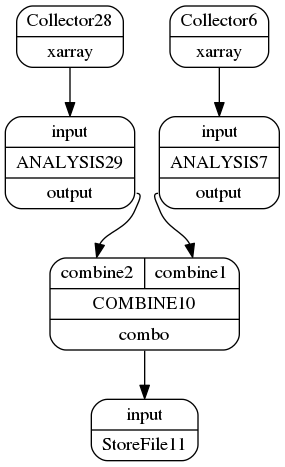

In [10]:
def createGraphWithProv():
    
    graph=createWorkflowGraph()
    #Location of the remote repository for runtime updates of the lineage traces. Shared among ProvenanceRecorder subtypes

    # Ranomdly generated unique identifier for the current run
    rid='JUP_SIMPLE_'+getUniqueId()

    
    # Finally, provenance enhanced graph is prepared:
    print prov_profile

     
    #Initialise provenance storage to service:
    profile_prov_run(graph, 
                     None,
                     provImpClass=(ProvenancePE,),
                     username=prov_profile['username'],
                     runId=rid,
                     w3c_prov=prov_profile['w3c_prov'],
                     description=prov_profile['description'],
                     workflowName=prov_profile['workflowName'],
                     workflowId=prov_profile['workflowId'],
                     save_mode=prov_profile['save_mode'],
                     componentsType=prov_profile['componentsType'],
                     skip_rules=prov_profile['skip_rules']
                    )
                   

    #clustersRecorders={'record0':ProvenanceRecorderToFileBulk,'record1':ProvenanceRecorderToFileBulk,'record2':ProvenanceRecorderToFileBulk,'record6':ProvenanceRecorderToFileBulk,'record3':ProvenanceRecorderToFileBulk,'record4':ProvenanceRecorderToFileBulk,'record5':ProvenanceRecorderToFileBulk}
    #Initialise provenance storage to sensors and Files:
    #profile_prov_run(graph,ProvenanceRecorderToFile,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor')
    #clustersRecorders=clustersRecorders)
    
    #Initialise provenance storage to sensors and service:
    #profile_prov_run(graph,ProvenanceRecorderToService,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor')
   
    #Summary view on each component
    #profile_prov_run(graph,ProvenanceTimedSensorToService,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor')
   
   
   
    #Configuring provenance feedback-loop
    #profile_prov_run(graph,ProvenanceTimedSensorToService,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor',feedbackPEs=['Source','MaxClique'])
   
   
    #Initialise provenance storage end associate a Provenance type with specific components:
    #profile_prov_run(graph,provImpClass=ProvenancePE,componentsType={'Source':(ProvenanceStock,)},username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='service')

    #
    return graph


graph=createGraphWithProv()

display(graph)

The workflow is rerun with provenace enabled.

In [11]:
runExampleWorkflow()

{'Collector': [{'input': ['data/new0.nc', 'data/newY.nc']}], 'Collector2': [{'input': ['data/new0.nc', 'data/newY.nc']}]}
SETTING NAME: SimpleProcessingPE
Collector6: ANDREJ.extractExternalInputDataId
Collector6: 'id'
Collector6: BUILDING INITIAL DERIVATION
Collector6: Read_Process
Collector6: {'input': ['data/new0.nc', 'data/newY.nc']}
Collector6: ANDREJ.extractItemMetadata
Collector6: ANDREJ.makeUniqueId
ANALYSIS7: Workflow_process
ANALYSIS7: ['input']
ANALYSIS7: ANDREJ.extractItemMetadata
ANALYSIS7: Checking Skip-Rules
ANALYSIS7: ANDREJ.makeUniqueId
Collector28: ANDREJ.extractExternalInputDataId
Collector28: 'id'
Collector28: BUILDING INITIAL DERIVATION
Collector28: Read_Process
Collector28: {'input': ['data/new0.nc', 'data/newY.nc']}
Collector28: ANDREJ.extractItemMetadata
Collector28: ANDREJ.makeUniqueId
ANALYSIS29: Workflow_process
ANALYSIS29: ['input']
ANALYSIS29: ANDREJ.extractItemMetadata
ANALYSIS29: ANDREJ.makeUniqueId
COMBINE10: Combine_process
COMBINE10: ['combine1']
COMBIN

The following link requires a local tomcat server to proxy to the provenance depo.


http://localhost:8180/provenance-explorer/html/view.jsp

The End

In [12]:
# output location.
finalFile = input_data['Collector'][0]['input'][1]
print finalFile

data/newY.nc


Visualis Output

!ncview data/newOut.nc

In [13]:
''' read id of output to locate prov '''
ds = xarray.open_dataset( finalFile )
dataid = ds.attrs['id']     #"orfeus-as-73355-c381c282-d422-11e6-ac42-f45c89acf865"

'''
https://github.com/aspinuso/dispel4py/blob/master/d4py-prov-xcorrelation-example.ipynb
'''
print("Extract Trace for dataid: "+dataid)
expurl = urlparse(ProvenancePE.PROV_EXPORT_URL)
connection = httplib.HTTPConnection(expurl.netloc)
print(expurl.netloc+expurl.path+dataid+"?all=true")
connection.request(
                "GET", expurl.path+dataid+"?all=true")
response = connection.getresponse()
print("progress: " + str((response.status, response.reason)))
prov1 = response.read()
print('PROV TO EMBED:')

Extract Trace for dataid: 16851412-dcbf-11e6-a47d-901b0e877023
climate4impact.eu/prov/workflow/export/data/16851412-dcbf-11e6-a47d-901b0e877023?all=true
progress: (200, '')
PROV TO EMBED:


In [14]:
print str(prov1)

<?xml version='1.0' encoding='ASCII'?>
<prov:document xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:dcterms="http://purl.org/dc/terms/" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:s-prov="http://s-prov">
  <prov:agent prov:id="s-prov:andrej">
    <dcterms:author>andrej</dcterms:author>
  </prov:agent>
  <prov:bundle prov:id="s-prov:JUP_SIMPLE_pc150396.knmi.nl-15522-1660470e-dcbf-11e6-a47d-901b0e877023">
    <s-prov:_id>JUP_SIMPLE_pc150396.knmi.nl-15522-1660470e-dcbf-11e6-a47d-901b0e877023</s-prov:_id>
    <s-prov:description>provdemo combo</s-prov:description>
    <s-prov:mapping>-f</s-prov:mapping>
    <s-prov:runId>JUP_SIMPLE_pc150396.knmi.nl-15522-1660470e-dcbf-11e6-a47d-901b0e877023</s-prov:runId>
    <s-prov:startTime>2017-01-17 14:13:15.464466</s-prov:startTime>
    <s-prov:type>workflow_run</s-prov:type>
    <s-prov:username>andrej</s-prov:username>
    <s-prov:workflowId>workflow process</s-prov:workflowId>
    <s-pro

In [15]:
#ds. create variable save to file

ds.load()
ds['provenance'] = xarray.DataArray("")

ds['provenance'].attrs['prov_xml']=str(prov1)

#


#print finalFile


ds.to_netcdf(str(finalFile+"_PROV"))


#
ds = xarray.open_dataset(str(finalFile+"_PROV"))
#
print ds


<xarray.Dataset>
Dimensions:     (time: 1, x: 424, y: 412)
Coordinates:
  * x           (x) float64 -44.62 -44.36 -44.1 -43.84 -43.58 -43.32 -43.06 ...
  * y           (y) float64 21.98 22.1 22.23 22.35 22.47 22.59 22.72 22.84 ...
  * time        (time) datetime64[ns] 2099-01-16
Data variables:
    vDTR        (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    crs         |S1 ''
    provenance  |S1 ''
Attributes:
    description: Tier 1: vDTR. Multi-year period of records.
    keywords: CLIP-C,Tier 1,vDTR,rcp85,SMHI-RCA4
    activity: CLIP-C project
    method: CLIVAR panel ETCCDI
    software: ADAGUC WCS Server version 2.0.15
    software_project: IS-ENES: climate for impact web portal
    software_reference: ICCLIM Documentation 3.0: https://media.readthedocs.org/pdf/icclim/latest/icclim.pdf
    institution: CERFACS
    institution_url: http://www.cerfacs.fr/globc
    summary: CLIPC Tier 1: vDTR. Multi-year period of records.
    in_var_project_id: CORDEX
    in_var

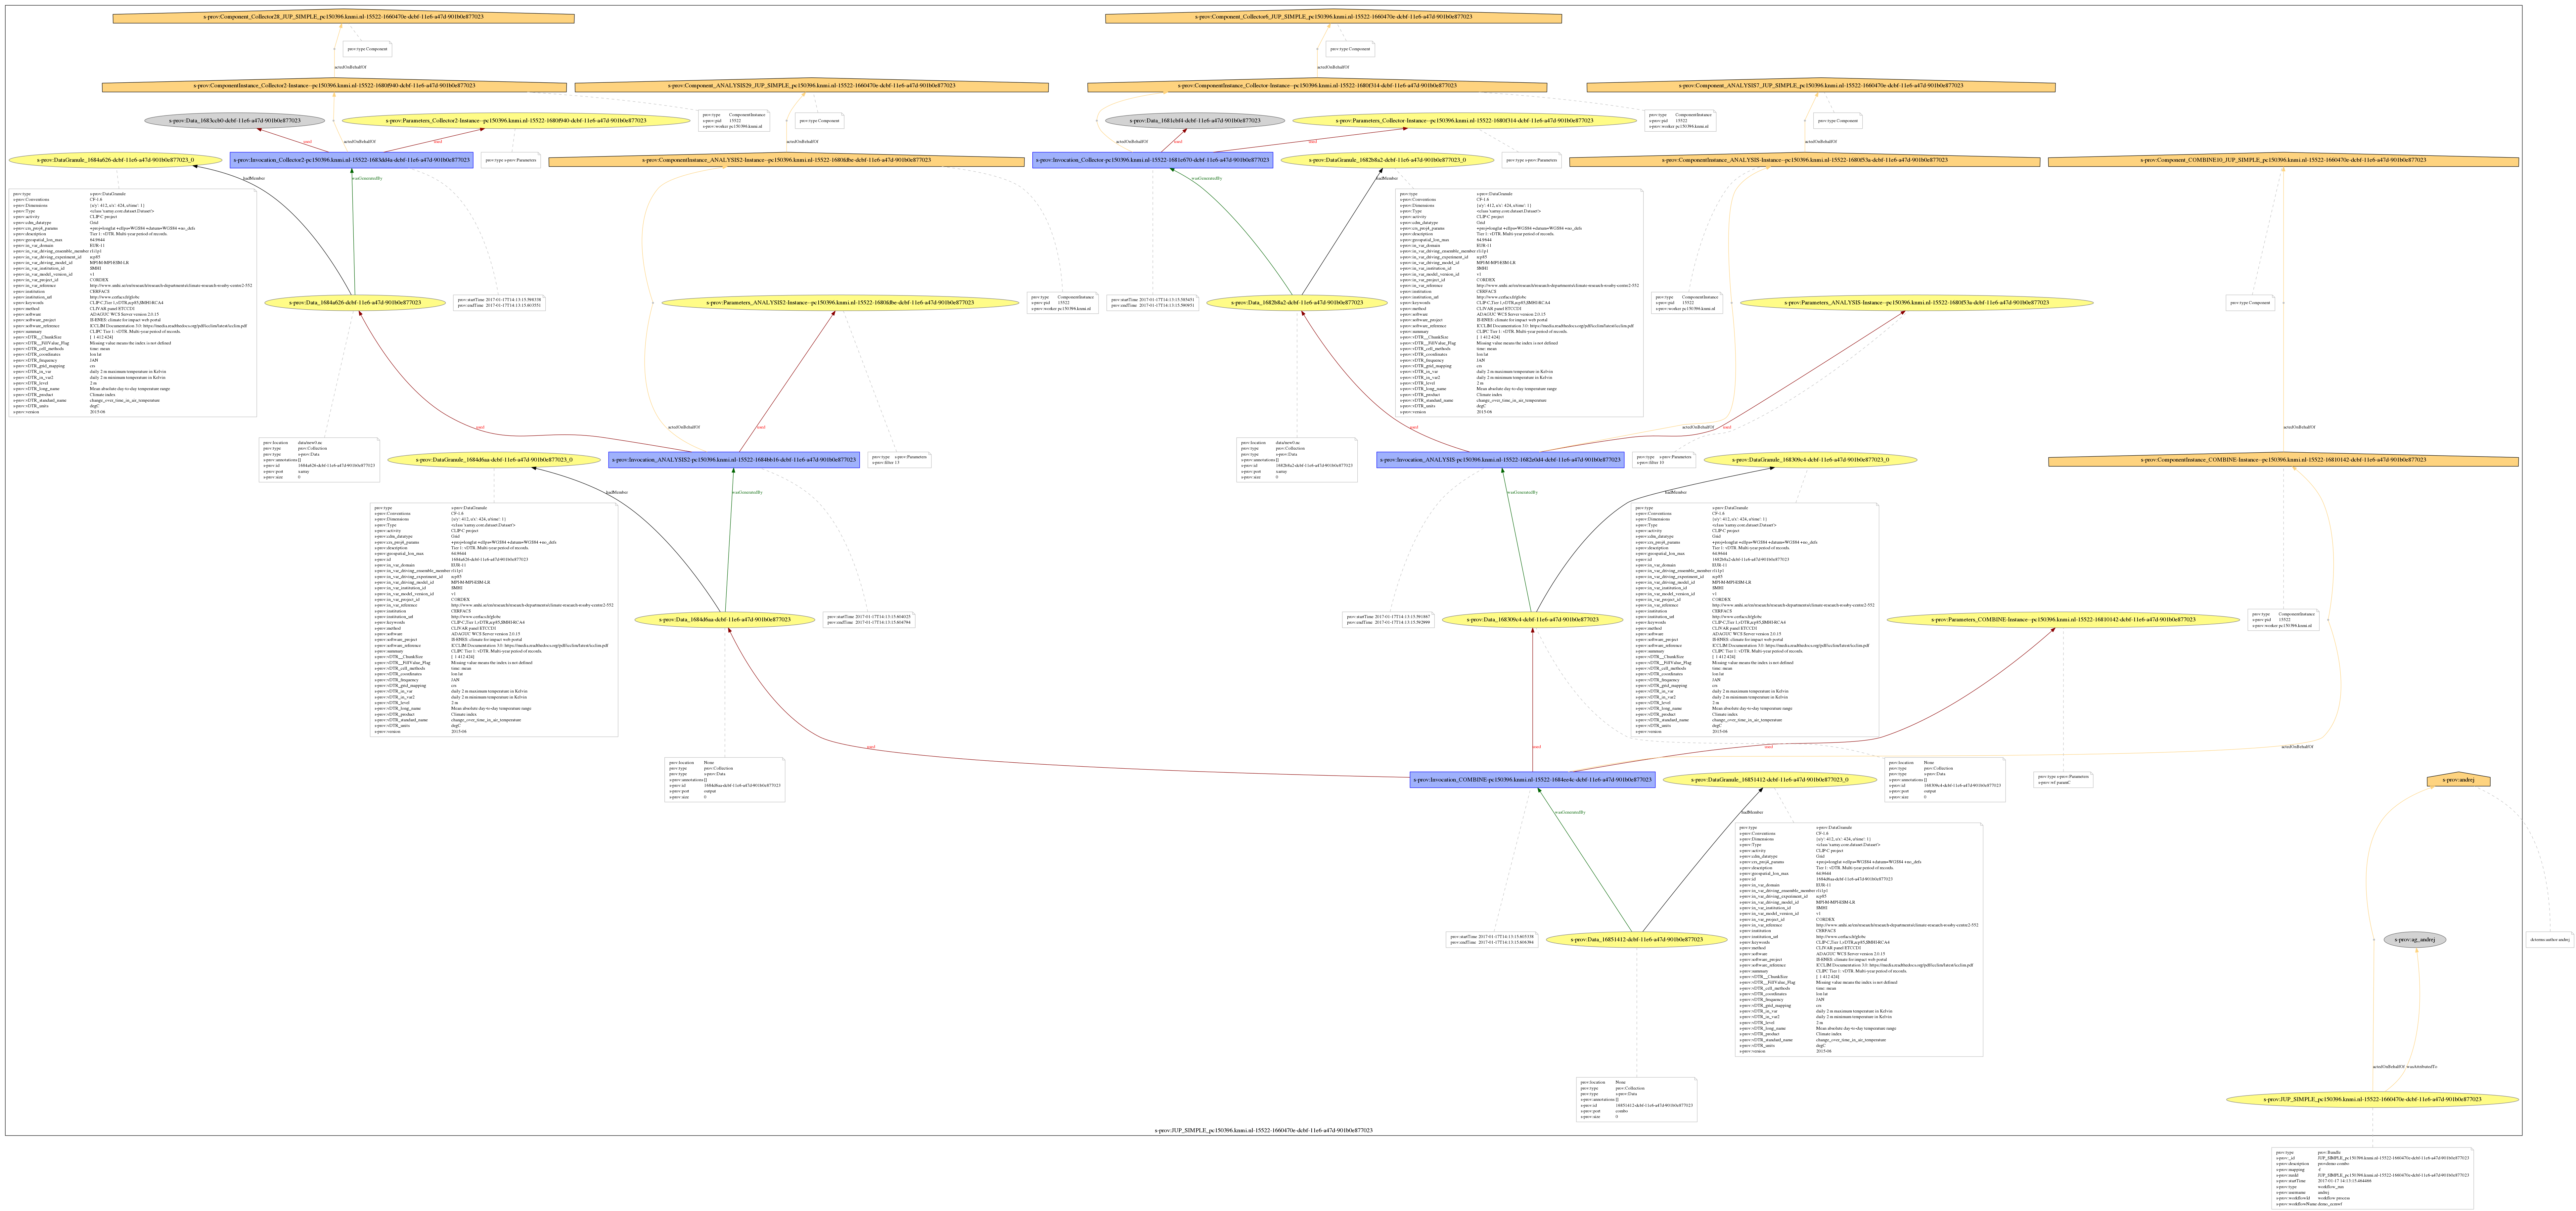

In [16]:
import prov
import io
import StringIO
from prov.model import ProvDocument, ProvBundle, ProvException, first, Literal
from prov.dot import prov_to_dot

def provToSvg(xml,output_f):
     
    xml_doc = StringIO.StringIO()
    xml_doc.write(str(xml))
    xml_doc.seek(0, 0)
    #print xml_doc
    doc=ProvDocument.deserialize(xml_doc,format="xml")
    dot = prov_to_dot(doc)
    return dot.create(format=output_f)
    

#prov_doc=open(prov).read()

#print prov1

svg_content=provToSvg(prov1,"png")

with open("PROV.png","w+") as text_file:
    text_file.write(str(svg_content))

from IPython.display import Image
Image("PROV.png")

    
# visualse NetCDF provenance in SVG

An example of the above W3C prov xml can be viewed using:

http://localhost:8180/provenance-explorer/html/view.jsp

https://provenance.ecs.soton.ac.uk/store/

https://provenance.ecs.soton.ac.uk/store/documents/115540.svg




the end.